# Diversity Measures

Based on "**Achieving Diversity in Counterfactual Explanations: a Review and Discussion**"

 by **Thibault Laugel and Adulam Jeyasothy et al.**

| Diversity Type          | Metric or Criterion               | Examples from Literature         |
|--------------------------|------------------------------------|-----------------------------------|
| **Criteria Diversity**   | Pareto spread, objective variance | Dandl et al. (2020), CARE (2022) |
| **Feature Diversity**    | \( l_0 \), \( l_2 \), cosine distance | Mothilal et al. (2020), DiVE (2021) |
| **Action Diversity**     | Jaccard distance, direction count | Russell (2019), Guidotti et al. (2019) |
| **Optimization Diversity** | Randomization, clustering         | CERTIFAI (2020), GeCo (2021)     |
| **Mixed Diversity (All Types)** | Custom definitions          | Tsirtsis et al. (2021), DECE (2020) |

### Pareto Spread
- **Definition**: Measures the spread of solutions along the Pareto front in multi-objective optimization.
- **Formula**:
  $$
  \text{Pareto Spread} = \sqrt{\sum_{i=1}^{k} \| f(e_i) - \bar{f} \|_2^2}
  $$
  Where:
  - $ f(e_i) $: Vector of objective values for the $i$-th counterfactual.
  - $ \bar{f} $: Centroid of the Pareto front (average of $ f(e_i) $).
  - $ k $: Number of counterfactuals.

This metric captures how far the solutions are distributed across the Pareto front.

---

### Objective Variance
- **Definition**: Quantifies the variability of individual objectives across a set of counterfactuals.
- **Formula**:
  $$
  \text{Objective Variance} = \frac{1}{k} \sum_{j=1}^{m} \text{Var}([f_j(e_1), f_j(e_2), \dots, f_j(e_k)])
  $$
  Where:
  - $ m $: Number of objectives.
  - $ f_j(e_i) $: Value of the $j$-th objective for the $i$-th counterfactual.
  - $ \text{Var} $: Variance function.

This metric evaluates how well the objectives differ across the generated counterfactuals.

---

Both metrics focus on diversity in the trade-offs between objectives, with Pareto Spread assessing distribution and Objective Variance quantifying variability.


# Method Experiments

### Objective Function

Given:
- $ \mathbf{x}' \sim p_{dist}(\mathbf{x}', \mathbf{x}) = \frac{1}{\lambda \|\mathbf{x} - \mathbf{x}'\|_2^2} $: Target variable (Counterfactual Explanation).
- $ \mathbf{x} \in \mathbb{R}^d $: Conditional variable (Data Point).
- $ p_\theta(\mathbf{x}' | \mathbf{x}) $: Conditional density modeled by the flow.

The optimization objective:
$$
\mathcal{L}(\theta) = - \log p_\theta(f_\theta(\mathbf{x}, \mathbf{x}')) - \log \left| \det \frac{\partial f_\theta(\mathbf{x}, \mathbf{x}')}{\partial \mathbf{x}} \right|
$$

### Optimization Problem

$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta).
$$

### Components
1. **Conditional Log-Likelihood**:
   $$
   -\log p_\theta(\mathbf{x} | \mathbf{x}').
   $$
2. **Regularization**: 
   $$
   \lambda \|\mathbf{x} - \mathbf{x}'\|_2^2.
   $$
3. **Trade-off**: Controlled by $ \lambda $.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm
from torch.utils.data import DataLoader, Dataset


from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlow, BaseGenModel
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
class PairDistanceDataset(Dataset):
    def __init__(self, class_zero, class_one, length=None):
        """
        Initialize with two arrays, one for each class.
        """
        self.length = length
        self.class_zero = torch.tensor(class_zero, dtype=torch.float32)
        self.class_one = torch.tensor(class_one, dtype=torch.float32)

        # Calculate pairwise distances between zero and one classes
        self.zero_one_distance = torch.cdist(self.class_zero, self.class_one) ** 4

        self.size_zero = class_zero.shape[0]
        self.size_one = class_one.shape[0]

    def __len__(self):
        # The total combinations are len(class_zero) * len(class_one)
        if self.length is not None:
            return self.length
        return self.size_zero * self.size_one

    def __getitem__(self, idx):
        """
        Randomly select a point from one class.
        Sample the second point based on the distance weight from another class.
        """
        if torch.rand(1) > 0.5:
            i = idx
            # i = torch.randint(0, self.size_zero, (1,)).item()
            x_orig = self.class_zero[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[i]
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_one[j]
        else:
            i = idx
            # i = torch.randint(0, self.size_one, (1,)).item()
            x_orig = self.class_one[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[:, i]
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

In [24]:
class PairDistanceDensityDataset(Dataset):
    def __init__(self, class_zero, class_one, gen_model: BaseGenModel, length=None):
        """
        Initialize with two arrays, one for each class.
        """
        self.length = length
        self.gen_model = gen_model
        self.class_zero = torch.tensor(class_zero, dtype=torch.float32)
        self.class_one = torch.tensor(class_one, dtype=torch.float32)

        # Calculate pairwise distances between zero and one classes
        self.zero_one_distance = torch.cdist(self.class_zero, self.class_one) ** 4
        self.zero_log_likelihood = self.gen_model(
            class_zero, torch.zeros(class_zero.shape[0])
        ).exp()
        self.one_log_likelihood = self.gen_model(
            class_one, torch.ones(class_one.shape[0])
        ).exp()

        self.size_zero = class_zero.shape[0]
        self.size_one = class_one.shape[0]

    def __len__(self):
        # The total combinations are len(class_zero) * len(class_one)
        if self.length is not None:
            return self.length
        return self.size_zero * self.size_one

    def __getitem__(self, idx):
        """
        Randomly select a point from one class.
        Sample the second point based on the distance weight from another class.
        """
        if torch.rand(1) > 0.5:
            i = torch.randint(0, self.size_zero, (1,)).item()
            x_orig = self.class_zero[i]

            # Calculate weights for sampling y
            zero_one_weight = (1 / self.zero_one_distance[i]) + self.one_log_likelihood
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_one[j]
        else:
            i = torch.randint(0, self.size_one, (1,)).item()
            x_orig = self.class_one[i]

            # Calculate weights for sampling y
            zero_one_weight = (
                1 / self.zero_one_distance[:, i] + self.zero_log_likelihood
            )
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

In [5]:
dataset = MoonsDataset(file_path="../data/moons.csv")

In [6]:
flow_train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.03
)
flow_test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.fit(flow_train_dataloader, flow_test_dataloader, num_epochs=1000, patience=50)

Epoch 205, Train: -1.2835, test: -1.4383, patience: 50:  20%|██        | 205/1000 [00:12<00:47, 16.86it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue 

In [5]:
dataset = MoonsDataset(file_path="../data/moons.csv")
disc_model = LogisticRegression(input_size=2, target_size=1)
train_dataloader = dataset.train_dataloader(batch_size=256, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=300, lr=1e-3)

Epoch 3850, Train: 0.2747, test: 0.2829, patience: 300:  38%|███▊      | 3850/10000 [00:13<00:21, 283.01it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/logistic_regression.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

In [7]:
dataset = MoonsDataset(file_path="../data/moons.csv")
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=300, lr=1e-3)
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

disc_model.eval()
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

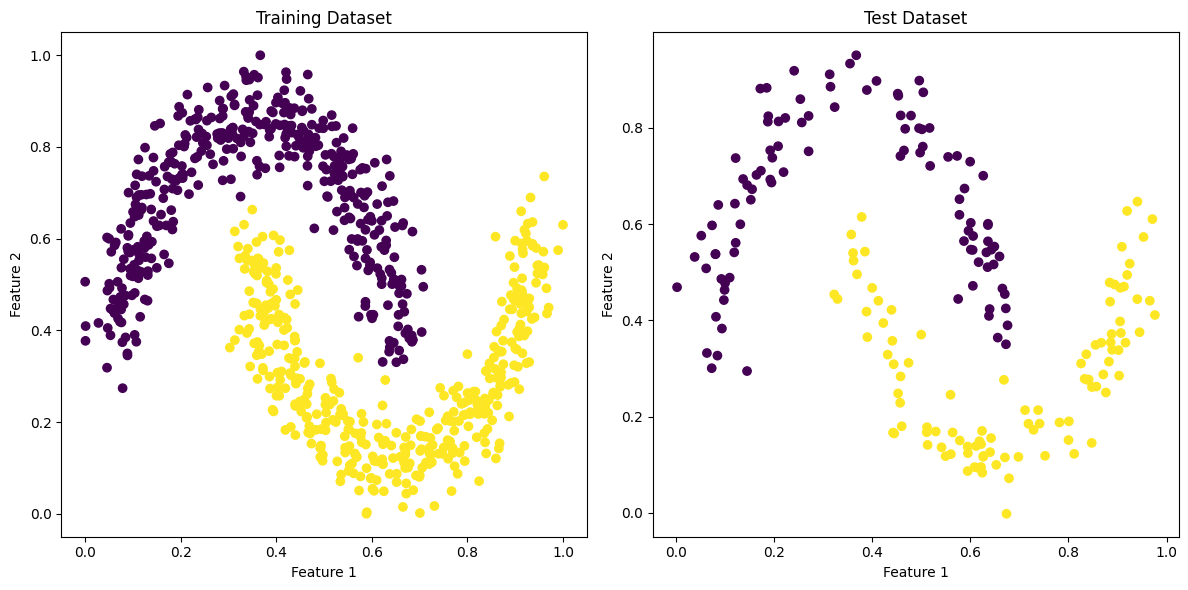

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training dataset
axes[0].scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='viridis', marker='o')
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot test dataset
axes[1].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap='viridis', marker='o')
axes[1].set_title('Test Dataset')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# PairDistanceDataset

In [36]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = PairDistanceDataset(class_zero, class_one, length=5000)


def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.stack(X)
    y = torch.stack(y)
    noise = torch.randn_like(X) * 0.03
    noise = torch.randn_like(y) * 0.03
    X = X + noise
    y = y + noise
    return X, y


train_dataloader = DataLoader(
    pair_dataset_train, batch_size=256, shuffle=True, collate_fn=collate_fn
)

/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_30118/2056348579.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(x_orig, dtype=torch.float32)


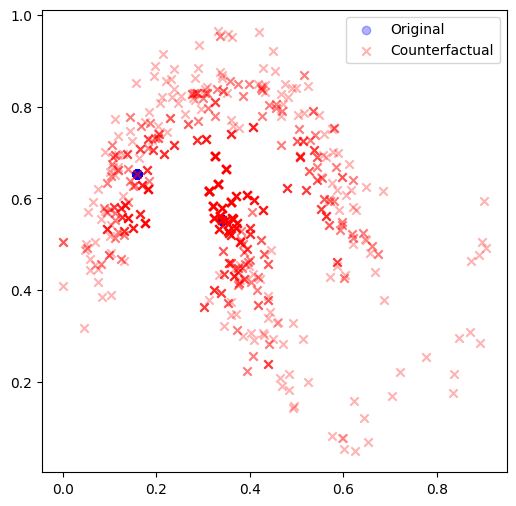

In [38]:
x_cfs, x_origs = [], []
for i in range(1000):
    x_cf, x_orig = pair_dataset_train[250]
    x_cfs.append(x_cf)
    x_origs.append(x_orig)
x_cfs = torch.vstack(x_cfs)
x_origs = torch.vstack(x_origs)

plt.figure(figsize=(6, 6))
plt.scatter(x_origs[:, 0], x_origs[:, 1], c='blue', marker='o', label='Original', alpha=0.3)
plt.scatter(x_cfs[:, 0], x_cfs[:, 1], c='red', marker='x', label='Counterfactual', alpha=0.3)
plt.legend()

In [11]:
class_zero = dataset.X_test[dataset.y_test == 0]
class_one = dataset.X_test[dataset.y_test == 1]

pair_dataset_test = PairDistanceDataset(class_zero, class_one)

test_dataloader = DataLoader(pair_dataset_test, batch_size=2048, shuffle=False)

In [48]:
cf = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=2,
)
cf.fit(
    train_dataloader, test_dataloader, num_epochs=1000, learning_rate=1e-3, patience=100
)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_23227/2507440124.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(x_orig, dtype=torch.float32)
Epoch 589, Train: -2.0699, test: -2.2305, patience: 100:  59%|█████▉    | 589/1000 [06:45<04:42,  1.45it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weight

In [30]:
from counterfactuals.plot_utils import plot_generative_model_distribution

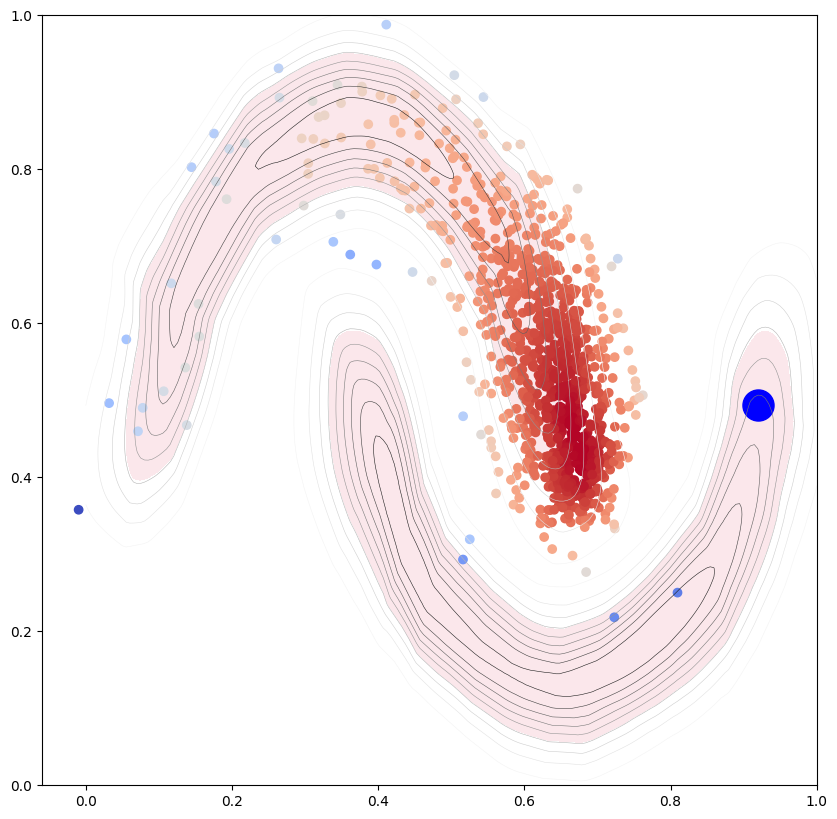

In [ ]:
i = 3
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        10, context=torch.from_numpy(np.array([class_one[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
# fig, ax = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_one[i, 0], class_one[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)

0. Poprawić wizualizacje.
1. Zwiększenie temperatury flow'a
2. Generacja z odfiltrowywaniem podobnych (+-)
3. Metryki z literatury + referencje innych metod
4. Metody referencyjne
5. Policzyć metryki które mamy dla par z losowaniem 1 punktu
6. Przetestować uczenie flow'a na kategorycznych

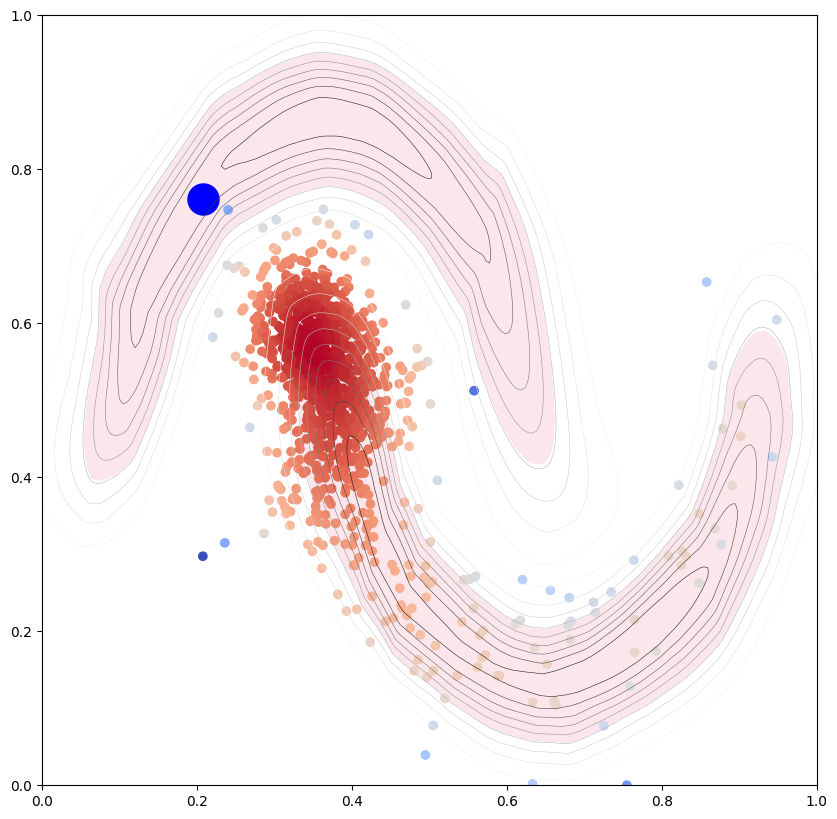

In [51]:
i = 1
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_zero[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_zero[i, 0], class_zero[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)

# PairDistanceDensityDataset

In [25]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = PairDistanceDensityDataset(
    torch.from_numpy(class_zero),
    torch.from_numpy(class_one),
    length=5000,
    gen_model=flow,
)


def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.stack(X)
    y = torch.stack(y)
    noise = torch.randn_like(X) * 0.03
    noise = torch.randn_like(y) * 0.03
    X = X + noise
    y = y + noise
    return X, y


train_dataloader = DataLoader(
    pair_dataset_train, batch_size=256, shuffle=True, collate_fn=collate_fn
)

/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_30118/3330342084.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_zero = torch.tensor(class_zero, dtype=torch.float32)
/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_30118/3330342084.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_one = torch.tensor(class_one, dtype=torch.float32)


/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_30118/3330342084.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(x_orig, dtype=torch.float32)


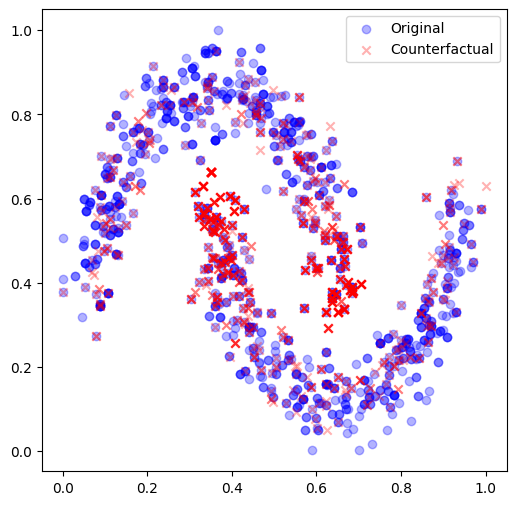

In [26]:
x_cfs, x_origs = [], []
for i in range(1000):
    x_cf, x_orig = pair_dataset_train[5]
    x_cfs.append(x_cf)
    x_origs.append(x_orig)
x_cfs = torch.vstack(x_cfs)
x_origs = torch.vstack(x_origs)

plt.figure(figsize=(6, 6))
plt.scatter(
    x_origs[:, 0], x_origs[:, 1], c="blue", marker="o", label="Original", alpha=0.3
)
plt.scatter(
    x_cfs[:, 0], x_cfs[:, 1], c="red", marker="x", label="Counterfactual", alpha=0.3
)
plt.legend()

In [27]:
class_zero = dataset.X_test[dataset.y_test == 0]
class_one = dataset.X_test[dataset.y_test == 1]

pair_dataset_test = PairDistanceDataset(class_zero, class_one)

test_dataloader = DataLoader(pair_dataset_test, batch_size=2048, shuffle=False)

In [28]:
cf = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=2,
)
cf.fit(
    train_dataloader, test_dataloader, num_epochs=1000, learning_rate=1e-3, patience=100
)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_30118/3330342084.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(x_orig, dtype=torch.float32)
/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_30118/125756958.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(x_orig, dtype=torch.float32)
Epoch 427, Train: -1.8615, test: -2.2581, patience: 100:  43%|████▎     | 427/1000 [06:02<08:06,  1.18it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf.py:154: FutureWarning: You are usi

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


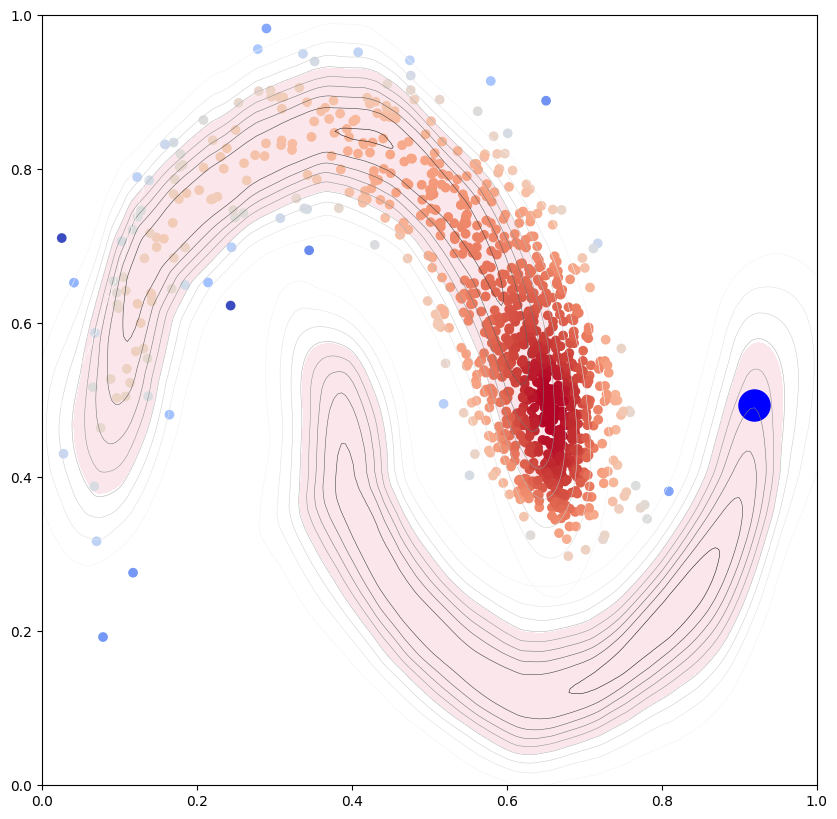

In [31]:
i = 3
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_one[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
# fig, ax = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_one[i, 0], class_one[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)

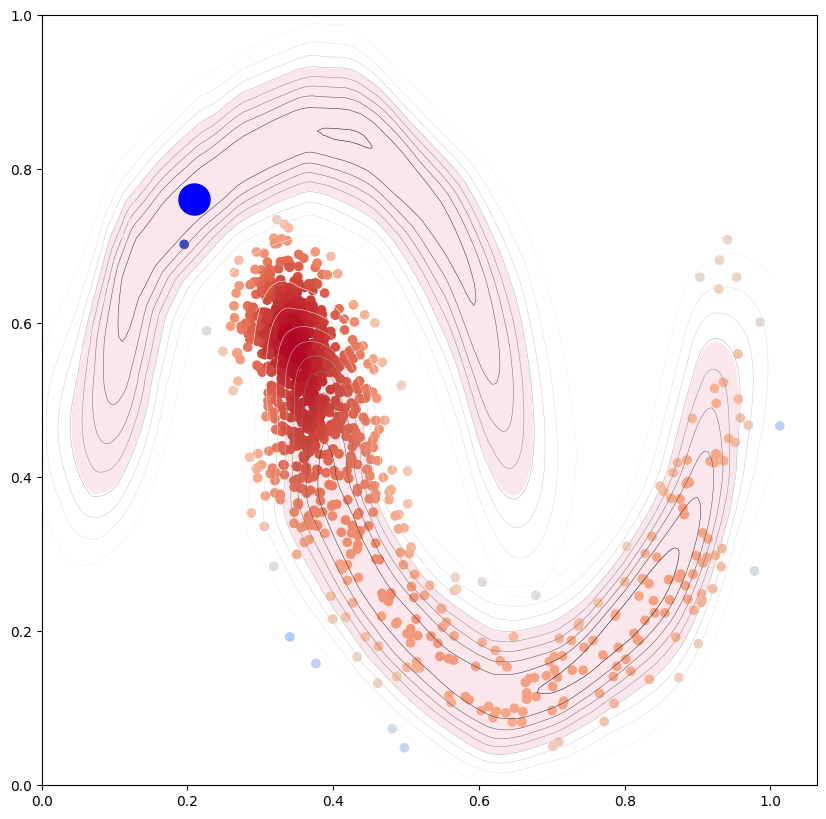

In [32]:
i = 1
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_zero[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_zero[i, 0], class_zero[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)